<a href="https://colab.research.google.com/github/chendwend/sky_removal/blob/main/Sightbit_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [1]:
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 21.5 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44089 sha256=a1bfaf1f81dbae70b1a629dd8c3d67fe767a16cb2bdff21b830b6f5eba663fc0
  Stored in directory: /root/.cache/pip/wheels/52/dd/2b/10ff8b0ac81b93946bb5fb9e6749bae2dac246506c8774e6cf
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/

# Imports

1.8.0+cu101 True


In [3]:
# check pytorch installation: 
import torch, torchvision
assert torch.__version__.startswith("1.8")   # please manually install torch 1.8 if Colab changes its default version
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import cv2
from google.colab.patches import cv2_imshow
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load example image

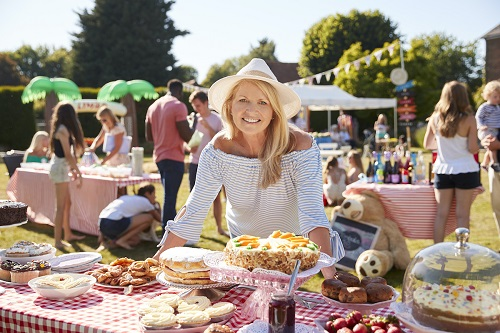

In [7]:
im = cv2.imread("image.png")
cv2_imshow(im)

# Load model

In [ ]:
model_name = "COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model_name))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_name)
cfg['MODEL']['DEVICE'] = device 
predictor = DefaultPredictor(cfg)

# Panoptic segmentation

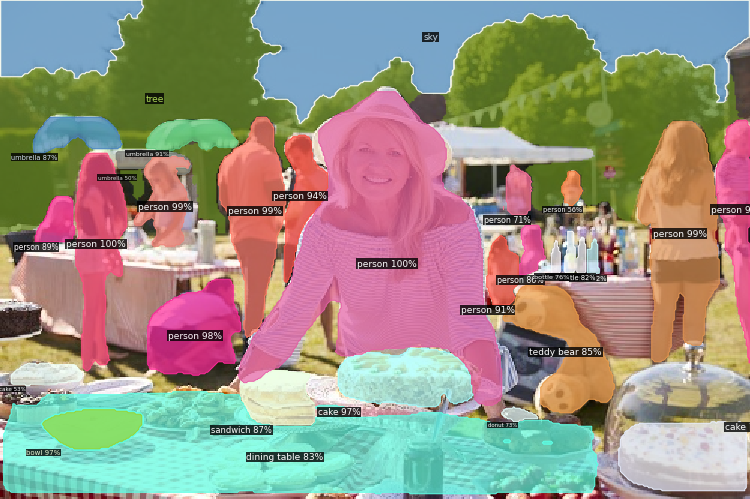

In [9]:
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.5)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])

# Find highest sky row index

In [10]:
sky_category_id = MetadataCatalog.get('coco_2017_train_panoptic_separated').as_dict()['stuff_classes'].index('sky')
for elem in segments_info:
  if elem['category_id'] == sky_category_id:
    sky_mask = elem['id']
    exit
sky_mask

30

In [11]:
sky_mask_tensor = torch.where(panoptic_seg==sky_mask,sky_mask,0)
highest_sky_row_index = sky_mask_tensor.nonzero()[:,0].max().item()
highest_sky_row_index

82

# Crop image

In [12]:
cropped_image = im[highest_sky_row_index+1:, :, :]
panoptic_seg_cropped = panoptic_seg[highest_sky_row_index+1:, :]
im.shape, cropped_image.shape, panoptic_seg_cropped.shape

((333, 500, 3), (250, 500, 3), torch.Size([250, 500]))

# Panoptic segmentation on cropped image

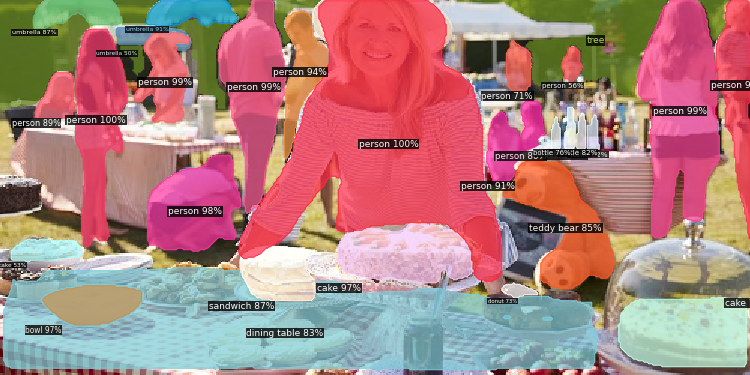

In [13]:
v = Visualizer(cropped_image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.5)
out = v.draw_panoptic_seg_predictions(panoptic_seg_cropped.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])

# Load Object Detection Model

In [14]:
model_name = "COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"
cfg_od = get_cfg() # od = object detection
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg_od.merge_from_file(model_zoo.get_config_file(model_name))
cfg_od.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg_od.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_name)
predictor = DefaultPredictor(cfg_od)
outputs = predictor(cropped_image)
# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file(model_name))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_name)
# cfg['MODEL']['DEVICE'] = device 
# predictor = DefaultPredictor(cfg)
# panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
# v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.5)
# out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
# cv2_imshow(out.get_image()[:, :, ::-1])

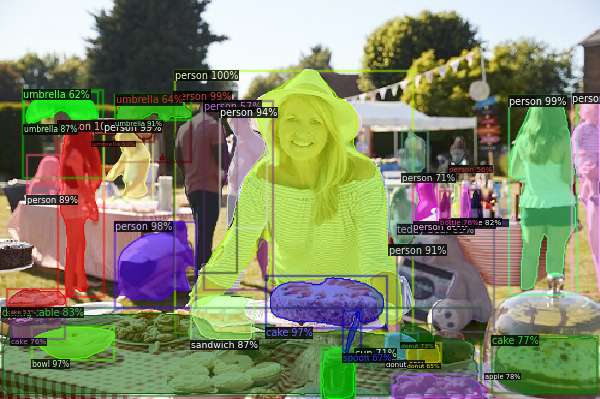

In [15]:
# We can use `Visualizer` to draw the predictions on the image.
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg_od.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# OD after cropping

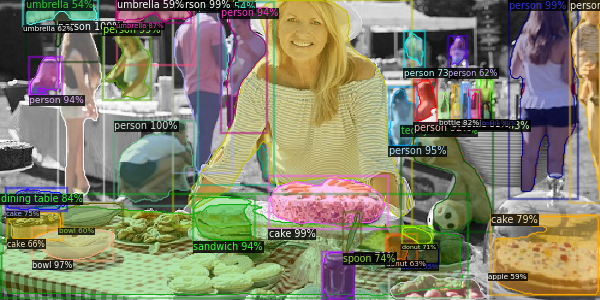

In [29]:
v = Visualizer(cropped_image[:, :, ::-1], MetadataCatalog.get(cfg_od.DATASETS.TRAIN[0]), scale=1.2,instance_mode = detectron2.utils.visualizer.ColorMode(2))
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

___

In [ ]:
dataset = fo.zoo.load_zoo_dataset("coco-2017")

___

In [ ]:
object_detection_model ="COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
skyline_detection_model: "COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip

--2022-12-23 11:54:02--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.108.59, 52.216.101.107, 52.216.57.169, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.108.59|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  25.5MB/s    in 10m 17s 

2022-12-23 12:04:19 (29.9 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



In [ ]:
!unzip train2017.zip